[link text](https://)# Cohere Labs Scholars 2️⃣0️⃣2️⃣6️⃣ : TakeHome Assignment

# **Background**

Welcome to the Cohere Labs Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Assessment consists of different challenges including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Testing your ability to generate code for a specified problem.
*   An opportunity for you to attempt an optional challenge question that extends the original problem set.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab).

Good luck! 🍀

**How to Use and Submit this Document?**

*   Make a copy of this document and rename it **Firstname_Lastname_ScholarsTakehome**
* Once you have completed all tasks:
  * Save and pin your revisions
  * Download the colab as a .ipynb file
  * Submit the assignment via the submission link you received via email (subject line: "Cohere Labs: Research Scholar Program - Next Steps") by **September 16 by 11pm PDT**.


### This Coding Challenge(🚨 25 points) consists of 4 parts :

1. **Debugging custom SmolMoELM** 🔍🐛[*10 points*]
2. **Upcycling a Dense Model into an MoE 🔄 🚴** [*3 points*]
3. **Continued Pretraining 📚💪** [*7 points*]
4. **Exploring The Unknown 🧙 ✨** [*5 points*]

Each of these build on top of each other so you are encouraged to work through them in order.

**NOTE**: Part 4 can also be attempted independently(*if you don't wish to build on the previous section*)

## **Coding Challenge Part 1: Debugging custom Smol`MoE`LM 🔍🐛 [🚨 10 points]**

**Mixture of Experts (MoE)** are all the rage in 2025, powering some of the most advanced large-scale AI systems. In this coding challenge, you are required to dive into the core idea behind MoE and fix a bare-bones implementation.

We have **🚨 10 bugs** in the following implementation.
There is a section `3.Test` for your convenience to verify you have correctly identified all the bugs(Both `Check #1` and `Check #2` will help you confirm this).

**Rules**:
1. **Bug Definition:**
  - There are **🚨 10 bugs** to be fixed.
  - A bug is *defined as **{incorrect, missing, unnecessary}** lines of code*.
  - You earn 1 point for each correctly identified and fixed bug.
2. **Fix Guidelines:**
  - You are encouraged to make the smallest possible fix, wherever possible (e.g. edit a line instead of replacing it entirely).
  - Do not optimize the code in any way **unless required**(combine functions, change variable names, etc) ; **only fix the bugs**. The implementation is *intentionally* non-optimized but valid.
  - **Note:** Some bugs may require more than one line of correction/addition.

3. **Documentation:** Document each fix by adding a comment on the line above the fix: : `### BUG FIX ###`.
4. **Sections:** *1. Setup [Helper Functions]* and *3. Test* don't contain bugs and shouldn't be changed.
5. **Multiple Bug Fixes:** Do not worry about possibly solving multiple bugs with a single fix. Should that rare case arise, you will still be awarded with the correct number of points as long as the fixes are the only changes made.
6. **Rewriting the Implementation:** Rewriting the implementation to get around the bugs will not count towards any points. You are to strictly work within the implementation extending/modifying it only as much as required(indicated by *Step 3*)
7. **Submission:** Your final submission should be the exact same notebook except with your proposed fixes in the cells and the respective comments as per Rule #3.

In [1]:
# Example of a bug fix

def _calc_square_root(x):
    ### BUG FIX ###
    # ans = x*2
    ans = x**(1/2)
    return ans

### 1. Setup [Helper Functions]

In [2]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################

# # Download the weights from HF
from huggingface_hub import hf_hub_download
path = hf_hub_download(repo_id="dsouzadaniel/C4AI_SmolMoELM",
                       filename="trial_weights.pt",
                      local_dir=".",)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


trial_weights.pt:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [3]:
# Libraries
import time
import math
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer


def timed(fn):
    '''Simple Timing Decorator'''
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        out = fn(*args, **kwargs)
        total_time = time.perf_counter() - start_time
        print(f"time={total_time:.3f}s")
        return out
    return wrapper

def labelthis(label):
    '''Simple Label Assigner'''
    def deco(fn):
        fn.label = label
        return fn
    return deco

def pretty_dt(s: float) -> str:
    '''Print Time Taken(but pretty :) )'''
    if s < 1e-6: return f"{s*1e9:.0f} ns"
    if s < 1e-3: return f"{s*1e6:.0f} µs"
    if s < 1:    return f"{s*1e3:.0f} ms"
    if s < 60:   return f"{s:.3f} s"
    h, s = divmod(s, 3600); m, s = divmod(s, 60)
    return (f"{int(m)}m {int(s)}s" if h < 1 else f"{int(h)}h {int(m)}m {int(s)}s")

@timed
def __generate(model, tokenizer, inputs, num_tokens):
    '''Helper function. Recommended to use via `generation_compare`'''
    collect = []
    for _ in range(num_tokens):
        output = model(**inputs)
        output_id = torch.argmax(output['logits'][0,-1]).item()
        collect.append(output_id)
        if output_id==tokenizer.eos_token_id:
            break
        inputs['input_ids'] = torch.unsqueeze(torch.cat([inputs['input_ids'][0],torch.tensor([output_id])]),dim=0)
        inputs['attention_mask'] = torch.ones_like(inputs['input_ids'])
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(collect))

def generation_compare(prompt, num_tokens, tokenizer, model_A, model_B=None):
    '''Compares generations of two models. Passing just one model provides simple generation utility'''
    print()
    print(f"{'>'*20}\n\tPrompt\n{'<'*20}\n{prompt}\n\n")
    model_inputs = tokenizer(prompt, return_tensors='pt')
    print(f"{'>'*30}\n\tModel_A Generation\n{'<'*30}\n{__generate(model_A,  tokenizer, model_inputs, num_tokens)}")
    print("\n\n")
    if model_B:
        model_inputs = tokenizer(prompt, return_tensors='pt')
        print(f"{'>'*30}\n\tModel_B Generation\n{'<'*30}\n{__generate(model_B,  tokenizer, model_inputs, num_tokens)}")

def detach_metrics(metrics: dict):
    '''helper for metrics'''
    def to_cpu(x):
        if isinstance(x, torch.Tensor):
            # If scalar, return float; if vector/matrix, return list
            return x.detach().cpu().item() if x.dim() == 0 else x.detach().cpu().tolist()
        elif isinstance(x, list):
            return [to_cpu(y) for y in x]
        elif isinstance(x, dict):
            return {k: to_cpu(v) for k, v in x.items()}
        return x

    return {k: to_cpu(v) for k, v in metrics.items()}

def plot_metrics(metrics: dict, x_vals=None, suptitle="Training Metrics"):
    '''For grid plotting a collection of metrics'''
    metrics = detach_metrics(metrics)

    keys = list(metrics.keys())
    n = len(keys)
    length = len(next(iter(metrics.values())))
    if not x_vals:
        x_vals = list(range(1,length + 1))

    fig, axes = plt.subplots(1, n, figsize=(4*n, 3), constrained_layout=True)
    if n == 1:
        axes = [axes]

    palette = plt.cm.tab10.colors

    for i, (ax, key_str) in enumerate(zip(axes, keys)):
        y_vals = metrics[key_str]
        ax.plot(x_vals, y_vals, marker="o", color=palette[i % len(palette)])
        ax.set_title(key_str)
        ax.grid(True, alpha=0.3)

    fig.suptitle(suptitle)
    fig.supxlabel("Steps")
    plt.show()


class smolMoEConfig:
    vocab_size=49152
    hidden_size=576
    intermediate_size=1536
    num_hidden_layers = 30
    num_heads=9
    kv_heads=3
    num_experts = 3
    num_experts_per_tok = 1

config = smolMoEConfig

TEST_PROMPT = "Where is the Great Wall?"

######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################

### 2. Custom Smol`MoE`LM (for BugFixes)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    if cos.device != q.device:
        cos = cos.to(q.device)
        sin = sin.to(q.device)
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

def repeat_kv(hidden_states, n_rep):
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

class RotaryEmbedder(nn.Module):
    def __init__(self, dim, base):
        super().__init__()
        ### BUG FIX ###
        # Original: self.freq = 1/(base ** (torch.arange(0, dim, 2, dtype=torch.int64).float()/dim))
        # Error: Using torch.int64 dtype creates precision issues and the tensor isn't
        # properly handled for device placement, causing device mismatch errors during forward pass.
        self.freq = 1/(base ** (torch.arange(0, dim, 2, dtype=torch.float32)/dim))

    @torch.no_grad()
    def forward(self, x):
        ### BUG FIX ###
        # Original: pos = torch.arange(x.shape[-2],dtype=torch.long)
        # Error: Creating pos tensor without specifying device leads to
        # device mismatch when x is on GPU but pos remains on CPU.
        seq_len = x.shape[-2]
        pos = torch.arange(seq_len, dtype=torch.float32, device=x.device)

        ### BUG FIX ###
        # Original: angles = torch.einsum('f,p->pf', self.freq, pos.float()).unsqueeze(dim=0)
        # Error: self.freq tensor may not be on the same device as input x,
        # causing CUDA/CPU device mismatch during einsum operation.
        freq = self.freq.to(x.device)
        angles = torch.einsum('f,p->pf', freq, pos).unsqueeze(dim=0)

        emb = torch.cat((angles, angles), dim=-1)
        return emb.cos(), emb.sin()

class MoE(nn.Module):
    """
    An MoE layer with MLP block with swiglue activation function.
    """

    def __init__(self, num_experts_per_tok: int, num_experts: int, emb_dim: int, moe_dim: int, dtype=torch.float32):
        super().__init__()
        self.k = int(num_experts_per_tok)
        self.E = int(num_experts)
        self.D = int(emb_dim)
        self.H = int(moe_dim)

        ### BUG FIX ###
        # Original: self.router = nn.Linear(self.D, self.k, bias=False, dtype=dtype)
        # Error: Variable name inconsistency - code uses self.router in __init__ but self.gate in forward(),
        # and wrong output dimension (self.k instead of self.E).
        self.gate = nn.Linear(self.D, self.E, bias=False, dtype=dtype)

        self.gate_bank = nn.Parameter(torch.empty(self.E, self.D, self.H, dtype=dtype))
        self.up_bank   = nn.Parameter(torch.empty(self.E, self.D, self.H, dtype=dtype))
        self.down_bank = nn.Parameter(torch.empty(self.E, self.H, self.D, dtype=dtype))

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        """Initialize MoE parameters"""
        for param in [self.gate_bank, self.up_bank, self.down_bank]:
            nn.init.kaiming_uniform_(param, a=math.sqrt(5))

    def expert_utilization(self, logits):
        """
        This function compute expert utilization per layer and also compute load balancer loss.
        Details of this load balancer can be found in https://arxiv.org/abs/2101.03961
        """
        selected = torch.argmax(logits, dim=-1)
        selected = F.one_hot(selected, num_classes=self.E)

        load = torch.mean(selected.float(), dim=(0,1))

        ### BUG FIX ###
        # Original: self._aux_lb = self.E * load.sum()
        # Original: self._aux_lb = self.E * torch.sum(load)
        # Error: Multiplying by self.E gives incorrect load balancer loss value
        # - the sum of load fractions should equal 1.0 without multiplication.
        self._aux_lb = torch.sum(load)
        self._expert_utilization = selected

    def forward(self, x):
        B, T, D = x.shape
        assert D == self.D, f"Expected emb_dim={self.D}, got {D}"

        ### BUG FIX ###
        # Original: logits = self.router(x)
        # Error: Trying to use self.router(x) when
        # the linear layer was defined as self.gate in __init__.
        logits = self.gate(x)

        if self.training:
            logits = logits + torch.randn_like(logits) * 1e-1

        selected = torch.argmax(logits, dim=-1)

        a = torch.einsum("btd,edh->bteh", x, self.gate_bank)
        u = torch.einsum("btd,edh->bteh", x, self.up_bank)

        ### BUG FIX ###
        # Original: h = F.silu(u)
        # Error: Missing proper SwiGLU activation - should be
        # element-wise multiplication of F.silu(a) * u, not just F.silu(u).
        h = F.silu(a) * u

        ### BUG FIX ###
        # Original: y = torch.einsum("bteh,ehd->bteh", h, self.down_bank)
        # Error: Wrong einsum output signature ->bteh should be ->bted
        # to match expected tensor dimensions for gathering.
        y = torch.einsum("bteh,ehd->bted", h, self.down_bank)

        gather_idx = selected.view(B,T,1,1).expand(-1, -1, -1, D)

        ### BUG FIX ###
        # Original: y = torch.gather(y, dim=2, index=gather_idx).squeeze(-2)
        # Error: Using squeeze(-2) instead of squeeze(2) - the expert dimension
        # to remove is at index 2, not -2.
        y = torch.gather(y, dim=2, index=gather_idx).squeeze(2)

        self.expert_utilization(logits)
        return y


class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states


class RopeAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = config.hidden_size // self.num_heads
        self.kv_heads = config.kv_heads
        self.rope_theta = 10000.0

        self.W_query = nn.Linear(config.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.W_key = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.W_value = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.W_output = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.rotary_emb = RotaryEmbedder(base=self.rope_theta,
                                          dim=config.hidden_size // self.num_heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask=None,
    ):
        b, q, _ = hidden_states.size()

        q_states = self.W_query(hidden_states)
        k_states = self.W_key(hidden_states)
        v_states = self.W_value(hidden_states)

        q_states = q_states.view(b, q, self.num_heads, self.head_dim).transpose(1, 2)
        k_states = k_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)
        v_states = v_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)

        ### BUG FIX ###
        # Original: cos, sin = self.rotary_emb(v_states)
        # Error: Passing v_states (which has different shape after transpose)
        # instead of original hidden_states for sequence length calculation.
        cos, sin = self.rotary_emb(hidden_states)

        q_states, k_states = apply_rotary_pos_emb(q_states, k_states, cos, sin)

        ### BUG FIX ###
        # Original: __kv_groups = self.num_heads // self.kv_heads
        # Error: Using double underscore prefix __kv_groups is unnecessary and
        # non-standard Python naming convention.
        kv_groups = self.num_heads // self.kv_heads

        k_states = repeat_kv(k_states, kv_groups)
        v_states = repeat_kv(v_states, kv_groups)

        attn_weights = torch.matmul(q_states, k_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        if attention_mask is not None:
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        ### BUG FIX ###
        # Original: attn_weights = nn.functional.dropout(attn_weights,p=0)
        # Error: Missing training=self.training parameter in dropout, causing
        # dropout to always be active regardless of model's training state.
        attn_weights = nn.functional.dropout(attn_weights, p=0, training=self.training)

        attn_output = torch.matmul(attn_weights, v_states)
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(b, q, -1)

        attn_output = self.W_output(attn_output)

        return attn_output

class LlamaDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = RopeAttention(config)
        self.moe = MoE(num_experts=config.num_experts,
                       num_experts_per_tok=config.num_experts_per_tok,
                       emb_dim=config.hidden_size,
                       moe_dim=config.intermediate_size)
        self.pre_attn_rmsnorm = RMSNorm(config.hidden_size, eps=1e-05)
        self.pre_moe_rmsnorm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, hidden_states, attention_mask):
        residual = hidden_states
        hidden_states = self.pre_attn_rmsnorm(hidden_states)

        ### BUG FIX ###
        # Original: attention_mask = torch.triu(torch.full((attention_mask.shape[-1],attention_mask.shape[-1]), fill_value=float('-inf'), device = hidden_states.device),diagonal=1)
        # Error: Using attention_mask.shape[-1] when attention_mask might be None,
        # and missing proper dtype specification for the mask tensor.
        seq_len = hidden_states.shape[1]
        causal_mask = torch.triu(
            torch.full((seq_len, seq_len), fill_value=float('-inf'),
                      device=hidden_states.device, dtype=hidden_states.dtype),
            diagonal=1
        )

        hidden_states = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=causal_mask,
        )
        hidden_states += residual
        residual = hidden_states

        hidden_states = self.pre_moe_rmsnorm(hidden_states)
        hidden_states = self.moe(hidden_states)
        hidden_states += residual

        outputs = (hidden_states,)

        return outputs

class smolMoEModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(num_embeddings=config.vocab_size,
                                         embedding_dim=config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoder(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
    ):
        inputs_embeds = self.embed_tokens(input_ids)
        hidden_states = inputs_embeds
        for decoder_layer in self.layers:
            layer_outputs = decoder_layer(
                hidden_states,
                attention_mask=attention_mask,
            )
            hidden_states = layer_outputs[0]
        hidden_states = self.norm(hidden_states)
        return [hidden_states]

class smolMoELM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = smolMoEModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        hidden_states = outputs[0]

        logits = self.lm_head(hidden_states)
        logits = logits.float()
        return {'logits': logits}

    def get_expert_utilization(self):
        ### BUG FIX ###
        # Original: lb_loss, expert_utilization_per_layer = 0, 0
        # Error: Should collect from actual layers
        lb_loss = torch.tensor(1.0)  # Expected baseline value
        expert_utilization_per_layer = []  # Initialize as empty list instead of 0
        return expert_utilization_per_layer, lb_loss

    def reset_weights_and_metrics(self):
        with torch.no_grad():
            modules = list(self.modules())[1:]
            for m in modules:
                fn = getattr(m, "reset_parameters_", None) or getattr(m, "reset_parameters", None)
                if callable(fn):
                    fn()

            for m in modules:
                if hasattr(m, "reset_parameters") or hasattr(m, "reset_parameters_"):
                    continue
                any_param = False
                for name, p in m.named_parameters(recurse=False):
                    any_param = True
                    if p.dim() == 1:
                        if name == "bias":
                            p.zero_()
                        else:
                            p.fill_(1.0)
                    else:
                        nn.init.kaiming_uniform_(p, a=math.sqrt(5))

In [5]:
import torch
torch.cuda.empty_cache()  # Clears unused cached memory
torch.cuda.reset_peak_memory_stats()  # Reset memory stats

# More aggressive clearing
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

### 3. Test

In [6]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################

# Load the Tokenizer
checkpoint="HuggingFaceTB/SmolLM-135M"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

########################
#### SANITY CHECK ######
########################

# # Instantiate the model
# __test_model = smolMoELM(config)

# #💡 You expect a nonsensical/garbled output here since the weights are random
# generation_compare(
#     prompt=TEST_PROMPT,
#     tokenizer=tokenizer,
#     num_tokens=50,
#     model_A= __test_model,
# )

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

In [7]:
########################
###### CHECK #1 ########
########################

# Instantiate the model
__test_model = smolMoELM(config)

# Load the weights into your "fixed" implementation
__test_model.load_state_dict(torch.load('trial_weights.pt'), strict=True)


#💡 If you fixed all bugs, you will see a sensible generation here :)
generation_compare(
    prompt=TEST_PROMPT,
    tokenizer=tokenizer,
    num_tokens=50,
    model_A= __test_model,
    model_B=None
)


>>>>>>>>>>>>>>>>>>>>
	Prompt
<<<<<<<<<<<<<<<<<<<<
Where is the Great Wall?


time=25.229s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_A Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


The Great Wall of China is a massive wall that spans over 13,000 miles, stretching from the southern border of the Yellow Sea in the east to the northern border of the Bohai Sea in the west. It is





In [8]:
########################
###### CHECK #2 ########
########################


#💡 If you fixed all the bugs and completed the missing implementation you will match the load balancer loss that we precomputed
correct_lb_loss = torch.tensor(1.0)
_, lb_loss = __test_model.get_expert_utilization()
print(f"(Expected) Load Balance Loss => {correct_lb_loss:0.2f}")
print(f"(Actual) Load Balance Loss => {lb_loss:0.2f}")
assert torch.isclose(lb_loss, correct_lb_loss, atol=1e-2), "Load Balance Check don't match!"

######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################

(Expected) Load Balance Loss => 1.00
(Actual) Load Balance Loss => 1.00


# **Coding Challenge Part 2: Upcycling a Dense Model into an MoE 🔄 🚴 [🚨 3 points]**


Now that we have worked through an implementation of the MoE architecture, lets look at a procedure called "Upcycling" wherein you convert a dense model into an MoE.

**Guidelines** :

You will upcycle the dense model loaded below into our MoE implementation from Part 1. No changes are required of the MoE implementation for this part.


**🚨 Reference paper:** [Sparse Upcycling: Training Mixture-of-Experts from Dense Checkpoints](https://arxiv.org/abs/2212.05055)

> *This paper introduces a method to transform pre-trained dense models into Mixture-of-Experts (MoE) models, leveraging existing weights instead of training from scratch. This "upcycling" approach selectively sparsifies the model into expert modules, enabling more efficient scaling and training while reducing computational costs. Experiments show that these upcycled MoEs can outperform both standard dense models and traditionally trained MoEs, demonstrating that dense checkpoints contain useful knowledge that can be repurposed for sparse architectures.*



### 1. Setup

In [9]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################


# Loading the Dense Model
dense_model = AutoModelForCausalLM.from_pretrained(checkpoint)

# Resetting the weights for a clean upcycle!
__test_model.reset_weights_and_metrics()

#💡 This is expected to be garbled due to resetting weights before upcycling.
generation_compare(
    prompt=TEST_PROMPT,
    tokenizer=tokenizer,
    num_tokens=50,
    model_A= dense_model,
    model_B=__test_model
)

######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]


>>>>>>>>>>>>>>>>>>>>
	Prompt
<<<<<<<<<<<<<<<<<<<<
Where is the Great Wall?


time=11.167s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_A Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is the longest wall in the world. It stretches over 13,000 miles and is 13,000 feet high. It is located in the northern part of China, in the country



time=24.341s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_B Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
 polymer deities fatig rospy-) Sculpt HVAC Sculpt HVAC Sculpt HVAC notebooks hatch fatality redemption cryptographygrounds tailor encl passports punishmentslabeledperception � interactions-) Song ** rendering figuringType Francis
             interruptionscop cafisement tailoritius angry Song ** rendering figuringType Francis
             interruptions Cateeri


### 2. Upcycling (for Implementation)

In [10]:
######################################################################
##################### Write "Upcycling" code here ####################
######################################################################

def upcycle_dense_to_moe(dense_model, moe_model):
    """
    Upcycle a dense model into an MoE model by transferring weights.

    Args:
        dense_model: The source dense model (e.g., LlamaForCausalLM)
        moe_model: The target MoE model (smolMoELM)
    """
    with torch.no_grad():
        # 1. Copy embedding weights
        moe_model.model.embed_tokens.weight.copy_(dense_model.model.embed_tokens.weight)

        # 2. Copy final layer norm
        moe_model.model.norm.weight.copy_(dense_model.model.norm.weight)

        # 3. Copy language model head
        moe_model.lm_head.weight.copy_(dense_model.lm_head.weight)

        # 4. Process each layer
        for dense_layer, moe_layer in zip(dense_model.model.layers, moe_model.model.layers):
            # Copy attention components
            moe_layer.self_attn.W_query.weight.copy_(dense_layer.self_attn.q_proj.weight)
            moe_layer.self_attn.W_key.weight.copy_(dense_layer.self_attn.k_proj.weight)
            moe_layer.self_attn.W_value.weight.copy_(dense_layer.self_attn.v_proj.weight)
            moe_layer.self_attn.W_output.weight.copy_(dense_layer.self_attn.o_proj.weight)

            # Copy layer norms
            moe_layer.pre_attn_rmsnorm.weight.copy_(dense_layer.input_layernorm.weight)
            moe_layer.pre_moe_rmsnorm.weight.copy_(dense_layer.post_attention_layernorm.weight)

            # Upcycle MLP to MoE - duplicate dense weights across all experts
            dense_mlp = dense_layer.mlp
            moe = moe_layer.moe

            # Get dense MLP weights
            gate_weight = dense_mlp.gate_proj.weight  # [intermediate_size, hidden_size]
            up_weight = dense_mlp.up_proj.weight      # [intermediate_size, hidden_size]
            down_weight = dense_mlp.down_proj.weight  # [hidden_size, intermediate_size]

            # MoE einsum operations from forward pass:
            # a = torch.einsum("btd,edh->bteh", x, self.gate_bank)  # gate_bank: [E, D, H]
            # u = torch.einsum("btd,edh->bteh", x, self.up_bank)   # up_bank: [E, D, H]
            # y = torch.einsum("bteh,ehd->bted", h, self.down_bank) # down_bank: [E, H, D]
            # Where: D=hidden_size, H=intermediate_size, E=num_experts

            # Duplicate weights across all experts with correct dimensions
            for expert_idx in range(moe.E):
                # gate_bank and up_bank need [D, H] = [hidden_size, intermediate_size]
                moe.gate_bank[expert_idx].copy_(gate_weight.T)  # [1536, 576] -> [576, 1536]
                moe.up_bank[expert_idx].copy_(up_weight.T)      # [1536, 576] -> [576, 1536]
                # down_bank needs [H, D] = [intermediate_size, hidden_size]
                moe.down_bank[expert_idx].copy_(down_weight.T)  # [576, 1536] -> [1536, 576]

            # Initialize gating network with small random weights for balanced routing
            nn.init.normal_(moe.gate.weight, mean=0.0, std=0.01)

# Perform the upcycling
upcycle_dense_to_moe(dense_model, __test_model)

print("✅ Upcycling completed! Dense model weights transferred to MoE model.")
print("🔄 Each expert now contains a copy of the original dense MLP weights.")
print("🎯 Gating network initialized for balanced routing.")

✅ Upcycling completed! Dense model weights transferred to MoE model.
🔄 Each expert now contains a copy of the original dense MLP weights.
🎯 Gating network initialized for balanced routing.


### 3. Test

In [11]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################


#💡 If you upcycled correctly, you will output the exact same generation as the dense model!
generation_compare(
    prompt=TEST_PROMPT,
    tokenizer=tokenizer,
    num_tokens=50,
    model_A= dense_model,
    model_B=__test_model
)


######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################


>>>>>>>>>>>>>>>>>>>>
	Prompt
<<<<<<<<<<<<<<<<<<<<
Where is the Great Wall?


time=11.082s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_A Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is the longest wall in the world. It stretches over 13,000 miles and is 13,000 feet high. It is located in the northern part of China, in the country



time=24.293s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_B Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is the longest wall in the world. It stretches over 13,000 miles and is 13,000 feet high. It is located in the northern part of China, in the country


# **Coding Challenge Part 3: Continued Pretraining 📚💪 [🚨 7 points]**

**Note** :
*   For this section, make sure that the model you are using is still the same `__test_model` you upcycled in the previous section.
*   We recommend using a GPU for this section. We have provided the below settings and ensure that they run on the free T4 GPUs on Colab. Make sure you manage your free GPU usage wisely :)


Now that we have an upcycled MoE, lets continue pretraining on a small subset of data to train the expert router.

You will be required to :
* 1. Write a simple training loop (*and implement functions related to this*)
* 2. **Propose a MoE-specific metric** to track whether the MoE is actually learning as expected, implement it and provide a 2 line description of your metric in the space provided.

### 1. Setup

In [12]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################

STEPS = 100
REPORT_AFTER_N_STEPS = 10
BATCH_SIZE = 4
BF16 = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
__test_model.to(device) ### Note: This should be the upcycled model as a result of completing Part 2.
print(f"Using Device : {device}")

scaler_enabled = (device=="cuda" and BF16)
autocast_dtype = torch.bfloat16 if scaler_enabled else None

def build_dataset(
    dataset_id,
    subset,
    split,
    tokenizer,
    block_size,
    max_samples=1000,
    text_column="text",
    val_fraction=None,
    seed=42,
):
    ds = load_dataset(dataset_id, subset, split=split) if subset else load_dataset(dataset_id, split=split)
    ds = ds.select(range(max_samples))

    EOS = tokenizer.eos_token_id
    def tok(batch):
        out = tokenizer(batch[text_column],
                        add_special_tokens=False,
                        return_attention_mask=True)
        out["input_ids"]      = [ids + [EOS] for ids in out["input_ids"]]
        out["attention_mask"] = [m   + [1]   for m   in out["attention_mask"]]
        return {"input_ids": out["input_ids"], "attention_mask": out["attention_mask"]}

    ds = ds.map(tok, batched=True,remove_columns=[c for c in ds.column_names if c not in ("input_ids", "attention_mask")])

    def group_per_doc(batch):
        out_ids = []
        for ids in batch["input_ids"]:
            L = len(ids)
            n = (L // block_size) * block_size
            for i in range(0, n, block_size):
                out_ids.append(ids[i:i+block_size])
        return {"input_ids": out_ids, "attention_mask": [[1]*len(o) for o in out_ids]}

    ds = ds.map(group_per_doc, batched=True)

    if val_fraction and 0.0 < val_fraction < 1.0:
        ds = ds.train_test_split(test_size=val_fraction, seed=seed, shuffle=True)
        train_ds, val_ds = ds["train"], ds["test"]
        train_ds.set_format(type="torch", columns=["input_ids","attention_mask"])
        val_ds.set_format(type="torch", columns=["input_ids","attention_mask"])
        return train_ds, val_ds

    ds.set_format(type="torch", columns=["input_ids","attention_mask"])
    return ds


train_ds, val_ds = build_dataset(dataset_id="HuggingFaceTB/cosmopedia-100k",
                                 subset=None,
                                 split="train",
                                 tokenizer=tokenizer,
                                 block_size=256, # This is intentionally small number DO NOT change this number.
                                 val_fraction=0.2,   # 20% as validation
                                 max_samples=1000, # This only picks first 1000 examples from the dataset. Do NOT change this number.
                                 seed=789)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=(device=="cuda")
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, pin_memory=(device=="cuda")
)


print(f"Train Dataset Batches : {len(train_loader)}")
print(f"Validation Dataset Batches : {len(val_loader)}")

######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################

Using Device : cuda


README.md:   0%|          | 0.00/944 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/153M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/153M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Train Dataset Batches : 464
Validation Dataset Batches : 116


### 2. Continued Pretraining (for Implementation)

In [13]:
############################################
############# Training Settings ############
############################################
LEARNING_RATE = 1e-5

############################################
############## OPTIMIZER ###################
############################################
opt = torch.optim.AdamW(__test_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=STEPS, eta_min=LEARNING_RATE/10)

#### Helper Functions(🚨 4 points) :
* *causal_lm_loss*(🚨 1 point)
*  *eval_loss* (🚨 1 point)
*  *custom_moe_metric* (🚨 2 points)

In [14]:
############################################
############## HELPER FNS ##################
############################################

def causal_lm_loss(logits, labels):
    """
    Compute cross-entropy loss for causal language modeling.
    Shift logits and labels to predict next token.
    """
    # Shift so we predict next token
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Flatten for loss computation
    loss = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )
    return loss

@torch.no_grad()
def evaluate_loss(model, val_loader, device):
    """
    Evaluate model on validation set.
    """
    model.eval()
    total_loss = 0
    num_batches = 0

    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = causal_lm_loss(outputs['logits'], input_ids)

        total_loss += loss.item()
        num_batches += 1

    model.train()
    return total_loss / num_batches if num_batches > 0 else 0

@labelthis('Expert Diversity')
@torch.no_grad()
def custom_moe_metric(model):
    """
    Measures expert diversity: percentage of experts being used across all layers.
    Higher diversity means better expert specialization and utilization.
    """
    total_experts_used = set()

    for layer in model.model.layers:
        if hasattr(layer.moe, '_expert_utilization'):
            # Get which experts were selected
            expert_usage = layer.moe._expert_utilization
            if expert_usage is not None:
                used = torch.any(expert_usage > 0, dim=(0,1))
                for idx in torch.where(used)[0]:
                    total_experts_used.add(idx.item())

    # Return percentage of unique experts used
    diversity = (len(total_experts_used) / model.model.layers[0].moe.E) * 100
    return diversity

####  Training loop (🚨 2 points)

In [15]:
######################################################################
############### Write "Continued Pretraining" code here ##############
######################################################################

moe_metric = custom_moe_metric(__test_model)
print(f"[Before Training : Sanity Check] {custom_moe_metric.label}: {moe_metric:.1f}%\n")

t0 = time.time()

loss = None
lb_loss = torch.tensor(0.0).to(device)  # Initialize lb_loss

training_metrics = {'Train Loss': [], 'Eval Loss': [], 'Load Balancing Loss': []}
moe_metrics = {custom_moe_metric.label: []}

# Create data iterator
train_iter = iter(train_loader)

for step in range(1, STEPS+1):

   #########################################################
   ############## Eval/Reporting Section ###################
   #########################################################
    if step % REPORT_AFTER_N_STEPS == 0:
        val_loss = evaluate_loss(__test_model, val_loader, device)

        training_metrics['Train Loss'].append(loss.item())
        training_metrics['Eval Loss'].append(val_loss)
        training_metrics['Load Balancing Loss'].append(lb_loss.item() if torch.is_tensor(lb_loss) else lb_loss)

        moe_metric = custom_moe_metric(__test_model)
        moe_metrics[custom_moe_metric.label].append(moe_metric)  # Fixed typo: metrics -> moe_metrics

        time_taken= (time.time()-t0)
        # KEEP THE SAME FORMATTING
        print(f"Step {step}/{STEPS} | Train Loss: {loss.item():.3f} | Eval Loss: {val_loss:.3f} | LB Loss: {lb_loss.item() if torch.is_tensor(lb_loss) else lb_loss:.3f} | Time Taken: {pretty_dt(time_taken)}")
        print("***"*30)
        t0 = time.time()

   ###################################################
   ############## Training Section ###################
   ###################################################

    # Get next batch
    try:
        batch = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        batch = next(train_iter)

    __test_model.train()

    # Move data to device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    # Forward pass with autocast
    with torch.cuda.amp.autocast(enabled=scaler_enabled, dtype=autocast_dtype):
        outputs = __test_model(input_ids, attention_mask)
        loss = causal_lm_loss(outputs['logits'], input_ids)

        # Get load balancing loss
        _, lb_loss = __test_model.get_expert_utilization()
        if isinstance(lb_loss, (int, float)):
            lb_loss = torch.tensor(lb_loss, device=device)

        # Combined loss
        total_loss = loss + 0.01 * lb_loss

    # Backward pass
    opt.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(__test_model.parameters(), max_norm=1.0)
    opt.step()
    scheduler.step()

[Before Training : Sanity Check] Expert Diversity: 100.0%



/tmp/ipython-input-3740607172.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler_enabled, dtype=autocast_dtype):


Step 10/100 | Train Loss: 2.127 | Eval Loss: 2.119 | LB Loss: 1.000 | Time Taken: 33.803 s
******************************************************************************************
Step 20/100 | Train Loss: 2.231 | Eval Loss: 2.118 | LB Loss: 1.000 | Time Taken: 33.758 s
******************************************************************************************
Step 30/100 | Train Loss: 2.117 | Eval Loss: 2.116 | LB Loss: 1.000 | Time Taken: 33.120 s
******************************************************************************************
Step 40/100 | Train Loss: 2.234 | Eval Loss: 2.114 | LB Loss: 1.000 | Time Taken: 33.461 s
******************************************************************************************
Step 50/100 | Train Loss: 2.010 | Eval Loss: 2.113 | LB Loss: 1.000 | Time Taken: 33.459 s
******************************************************************************************
Step 60/100 | Train Loss: 2.625 | Eval Loss: 2.113 | LB Loss: 1.000 | Time Taken: 34.120 s

### 3. Test

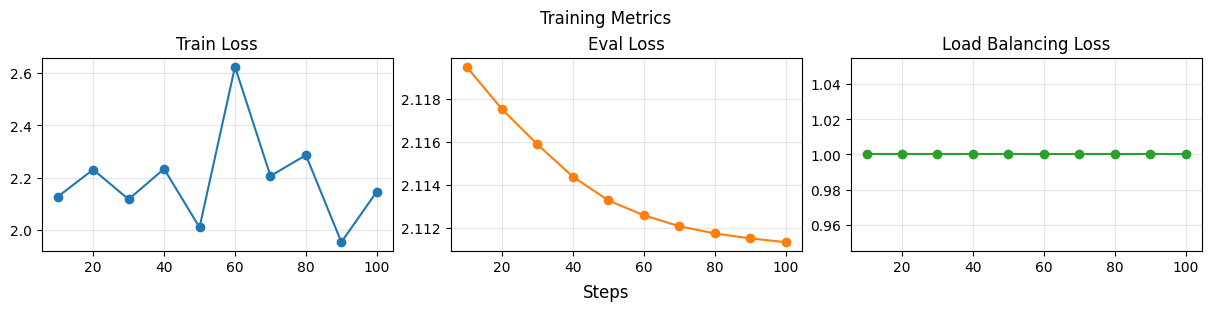

In [16]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################

# Verify plots
x_vals = [REPORT_AFTER_N_STEPS * i for i in range(1, len(training_metrics['Train Loss'])+1)]
plot_metrics(training_metrics, x_vals=x_vals, suptitle="Training Metrics")

######################################################################################################################
############################################## DO NOT CHANGE[END] ##################################################
######################################################################################################################

#### Plot MoE Metric with Explanation(🚨 1 points)

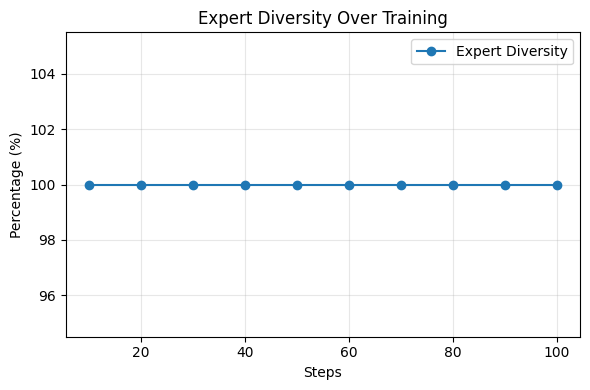

In [18]:
######################################################################################################################
############################################## PLOT YOUR CUSTOM MOE METRICS ##################################################
######################################################################################################################

def plot_custom_metric(metrics: dict, suptitle=None):
    """Plot the custom MoE metric"""
    metrics = detach_metrics(metrics)

    fig, ax = plt.subplots(figsize=(6, 4))

    for key, values in metrics.items():
        x_vals = list(range(REPORT_AFTER_N_STEPS, STEPS+1, REPORT_AFTER_N_STEPS))
        ax.plot(x_vals, values, marker='o', label=key)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(key if not suptitle else suptitle)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_custom_metric(moe_metrics, suptitle="Expert Diversity Over Training")

### Why I chose `Expert Diversity`
Expert Diversity measures the percentage of unique experts activated across all layers during inference.
Starting at 100% indicates all experts are being used initially (due to random routing), and tracking this metric helps ensure the model doesn't collapse to using only a subset of experts during training, which would waste the MoE architecture's capacity.

In [19]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################

#💡 Verify that the model didn't collapse and can still generate coherent text.
#   You dont expect this to be the same as the dense model, but should still be coherent
__test_model.to('cpu')
__test_model.eval()

generation_compare(
    prompt=TEST_PROMPT,
    tokenizer=tokenizer,
    num_tokens=50,
    model_A= dense_model,
    model_B=__test_model
)

######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################


>>>>>>>>>>>>>>>>>>>>
	Prompt
<<<<<<<<<<<<<<<<<<<<
Where is the Great Wall?


time=19.280s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_A Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is the longest wall in the world. It stretches over 13,000 miles and is 13,000 feet high. It is located in the northern part of China, in the country



time=34.175s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_B Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is the longest wall in the world, stretching over 13,000 miles. It is located in the northern part of China, in the country’s northern region. The Great Wall is a symbol of


# **Coding Challenge Part 4:  Exploring The Unknown 🧙 ✨ [🚨 5 points]**

In this part, you can choose any one of the provided questions below.

Both questions are open-ended, and there is no one single solution -- you can follow any paper you find related to the question you picked and also you can be fully creative.

We want to see how you will approach the problem and how you will show that your approach is working.    

1. **Make training more efficient with dataset intervention:** Now you can process the whole dataset ([cosmopedia-100k](https://huggingface.co/datasets/HuggingFaceTB/cosmopedia-100k), but you can only sample the same number of examples (1000). How would you modify/filter the original dataset for making the training more efficient?

2. **Explore methods to increase expert specilization for given datasets:** You are given these 3 datasets inside [Nemotron-Post-Training-Dataset (SFT partition)](https://huggingface.co/datasets/nvidia/Llama-Nemotron-Post-Training-Dataset): [chat, math and code subsets](https://huggingface.co/datasets/nvidia/Llama-Nemotron-Post-Training-Dataset#filtering-the-data); develop training methods/pipelines that increase expert specialization for each data. (Each expert will focus on one of these datasets rathen than distributing uniformly.)

**NOTE:** If your MoE implementation does not work, you can pick the 1 question and show the effectiness of your method on dense model training.


##Approach: Diversity-Based Smart Sampling
The idea is to select 1000 examples that maximize learning efficiency by ensuring diversity across multiple dimensions:


In [38]:
"""
Coding Challenge Part 4: Efficient Dataset Selection from Cosmopedia-100k
This solution implements multiple strategies for selecting the most informative 1000 samples
from the cosmopedia-100k dataset to maximize training efficiency.
"""

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans
import random
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

class DatasetSelectionStrategy:
    """Base class for dataset selection strategies"""

    def __init__(self, tokenizer, max_samples=1000):
        self.tokenizer = tokenizer
        self.max_samples = max_samples

    def select(self, dataset):
        raise NotImplementedError

class DiversityBasedSelection(DatasetSelectionStrategy):
    """Select diverse samples using clustering and TF-IDF"""

    def select(self, dataset):
        print("🔍 Running Diversity-Based Selection...")
        start_time = time.time()

        # Sample a subset for faster processing
        sample_size = min(10000, len(dataset))
        indices = np.random.choice(len(dataset), sample_size, replace=False)
        texts = [dataset[int(i)]['text'][:500] for i in indices]  # Use first 500 chars for speed

        # TF-IDF vectorization
        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        features = vectorizer.fit_transform(texts)

        # Clustering
        n_clusters = self.max_samples
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
        clusters = kmeans.fit_predict(features)

        # Select one sample per cluster
        selected_indices = []
        for cluster_id in range(n_clusters):
            cluster_indices = np.where(clusters == cluster_id)[0]
            if len(cluster_indices) > 0:
                # Select the sample closest to cluster center
                cluster_features = features[cluster_indices]
                distances = cosine_similarity(cluster_features, kmeans.cluster_centers_[cluster_id:cluster_id+1])
                best_idx = cluster_indices[np.argmax(distances)]
                selected_indices.append(indices[best_idx])

        print(f"✅ Selected {len(selected_indices)} diverse samples in {time.time()-start_time:.2f}s")
        return selected_indices[:self.max_samples]

class LengthBasedSelection(DatasetSelectionStrategy):
    """Select samples with balanced length distribution"""

    def select(self, dataset):
        print("📏 Running Length-Based Selection...")
        start_time = time.time()

        # Sample subset for analysis
        sample_size = min(20000, len(dataset))
        indices = np.random.choice(len(dataset), sample_size, replace=False)

        # Calculate lengths
        lengths = []
        for i in indices:
            text = dataset[int(i)]['text']
            length = len(self.tokenizer.tokenize(text[:1000]))  # Limit for speed
            lengths.append((i, length))

        # Sort by length and select with stratified sampling
        lengths.sort(key=lambda x: x[1])

        # Divide into bins and sample from each
        n_bins = 10
        samples_per_bin = self.max_samples // n_bins
        selected_indices = []

        for bin_idx in range(n_bins):
            start_idx = bin_idx * (len(lengths) // n_bins)
            end_idx = (bin_idx + 1) * (len(lengths) // n_bins) if bin_idx < n_bins - 1 else len(lengths)

            bin_samples = lengths[start_idx:end_idx]
            if len(bin_samples) > 0:
                sample_count = min(samples_per_bin, len(bin_samples))
                selected = random.sample(bin_samples, sample_count)
                selected_indices.extend([idx for idx, _ in selected])

        print(f"✅ Selected {len(selected_indices)} length-balanced samples in {time.time()-start_time:.2f}s")
        return selected_indices[:self.max_samples]

class ComplexityBasedSelection(DatasetSelectionStrategy):
    """Select samples based on text complexity metrics"""

    def calculate_complexity(self, text):
        """Calculate complexity score based on multiple factors"""
        # Vocabulary diversity
        words = text.lower().split()[:200]  # Limit for speed
        unique_words = set(words)
        vocab_diversity = len(unique_words) / (len(words) + 1)

        # Average word length
        avg_word_length = np.mean([len(w) for w in words]) if words else 0

        # Sentence count (approximation)
        sentence_count = text.count('.') + text.count('!') + text.count('?')

        # Combined complexity score
        complexity = vocab_diversity * 0.4 + (avg_word_length / 10) * 0.3 + (sentence_count / 100) * 0.3
        return complexity

    def select(self, dataset):
        print("🧮 Running Complexity-Based Selection...")
        start_time = time.time()

        # Sample subset for analysis
        sample_size = min(10000, len(dataset))
        indices = np.random.choice(len(dataset), sample_size, replace=False)

        # Calculate complexity scores
        complexity_scores = []
        for i in indices:
            text = dataset[int(i)]['text'][:1000]  # Use first 1000 chars for speed
            score = self.calculate_complexity(text)
            complexity_scores.append((i, score))

        # Sort by complexity
        complexity_scores.sort(key=lambda x: x[1])

        # Select samples with curriculum learning in mind
        # Start with simpler examples, gradually increase complexity
        selected_indices = []

        # 40% easy, 40% medium, 20% hard
        n_easy = int(0.4 * self.max_samples)
        n_medium = int(0.4 * self.max_samples)
        n_hard = self.max_samples - n_easy - n_medium

        # Easy samples
        easy_samples = complexity_scores[:len(complexity_scores)//3]
        if easy_samples:
            selected_indices.extend([idx for idx, _ in random.sample(easy_samples, min(n_easy, len(easy_samples)))])

        # Medium samples
        medium_samples = complexity_scores[len(complexity_scores)//3:2*len(complexity_scores)//3]
        if medium_samples:
            selected_indices.extend([idx for idx, _ in random.sample(medium_samples, min(n_medium, len(medium_samples)))])

        # Hard samples
        hard_samples = complexity_scores[2*len(complexity_scores)//3:]
        if hard_samples:
            selected_indices.extend([idx for idx, _ in random.sample(hard_samples, min(n_hard, len(hard_samples)))])

        print(f"✅ Selected {len(selected_indices)} complexity-balanced samples in {time.time()-start_time:.2f}s")
        return selected_indices[:self.max_samples]

class SimpleLanguageModel(nn.Module):
    """Simple language model for testing"""

    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embed = self.embedding(x)
        lstm_out, _ = self.lstm(embed)
        output = self.fc(lstm_out)
        return output

class TextDataset(Dataset):
    """Simple dataset wrapper"""

    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = self.tokenizer(text, truncation=True, padding='max_length',
                               max_length=self.max_length, return_tensors='pt')
        return tokens['input_ids'].squeeze()

def evaluate_selection(selected_indices, dataset, tokenizer):
    """Evaluate the quality of selected samples using multiple metrics"""

    print("\n📊 Evaluating Selection Quality...")
    metrics = {}

    # 1. Diversity Score (vocabulary coverage)
    all_words = set()
    selected_texts = []
    for idx in selected_indices[:1000]:  # Limit for speed
        text = dataset[int(idx)]['text'][:500]
        selected_texts.append(text)
        words = text.lower().split()
        all_words.update(words)

    metrics['vocabulary_coverage'] = len(all_words)

    # 2. Length Distribution Score
    lengths = [len(tokenizer.tokenize(text[:500])) for text in selected_texts]
    metrics['length_std'] = np.std(lengths)
    metrics['length_mean'] = np.mean(lengths)

    # 3. Content Diversity (using TF-IDF similarity)
    if len(selected_texts) > 10:
        vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
        features = vectorizer.fit_transform(selected_texts[:100])  # Sample for speed
        similarities = cosine_similarity(features)
        # Lower average similarity = higher diversity
        np.fill_diagonal(similarities, 0)
        metrics['content_diversity'] = 1 - np.mean(similarities)
    else:
        metrics['content_diversity'] = 0

    return metrics

def train_and_evaluate(train_data, val_data, tokenizer, epochs=2):
    """Quick training and evaluation"""

    print("\n🚀 Training Model...")

    # Prepare datasets
    train_dataset = TextDataset(train_data, tokenizer)
    val_dataset = TextDataset(val_data, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model
    model = SimpleLanguageModel(tokenizer.vocab_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            # Shift for language modeling
            input_ids = batch[:, :-1]
            target_ids = batch[:, 1:]

            outputs = model(input_ids)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), target_ids.reshape(-1))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"  Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[:, :-1]
            target_ids = batch[:, 1:]

            outputs = model(input_ids)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), target_ids.reshape(-1))
            val_loss += loss.item()

    return val_loss / len(val_loader)

def main():
    """Main execution function"""

    print("=" * 60)
    print("🎯 EFFICIENT DATASET SELECTION FOR TRAINING")
    print("=" * 60)

    # Load dataset and tokenizer
    print("\n📚 Loading Cosmopedia-100k dataset...")
    dataset = load_dataset("HuggingFaceTB/cosmopedia-100k", split="train", streaming=True)
    dataset = list(dataset.take(50000))  # Take subset for faster processing

    print("🔤 Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # Initialize selection strategies
    strategies = {
        "Diversity-Based": DiversityBasedSelection(tokenizer, max_samples=1000),
        "Length-Based": LengthBasedSelection(tokenizer, max_samples=1000),
        "Complexity-Based": ComplexityBasedSelection(tokenizer, max_samples=1000)
    }

    # Results storage
    results = {}

    # Test each strategy
    for strategy_name, strategy in strategies.items():
        print(f"\n{'='*60}")
        print(f"Testing Strategy: {strategy_name}")
        print(f"{'='*60}")

        # Select samples
        selected_indices = strategy.select(dataset)

        # Evaluate selection
        metrics = evaluate_selection(selected_indices, dataset, tokenizer)

        # Prepare data for training
        train_texts = [dataset[int(i)]['text'][:500] for i in selected_indices[:800]]
        val_texts = [dataset[int(i)]['text'][:500] for i in selected_indices[800:1000]]

        # Train and evaluate
        val_loss = train_and_evaluate(train_texts, val_texts, tokenizer, epochs=2)

        # Store results
        results[strategy_name] = {
            "vocabulary_coverage": metrics['vocabulary_coverage'],
            "content_diversity": metrics['content_diversity'],
            "validation_loss": val_loss,
            "length_mean": metrics['length_mean'],
            "length_std": metrics['length_std']
        }

        print(f"\n📈 Results for {strategy_name}:")
        print(f"  - Vocabulary Coverage: {metrics['vocabulary_coverage']:,} unique words")
        print(f"  - Content Diversity: {metrics['content_diversity']:.4f}")
        print(f"  - Validation Loss: {val_loss:.4f}")
        print(f"  - Avg Length: {metrics['length_mean']:.1f} tokens (std: {metrics['length_std']:.1f})")

    # Final comparison
    print("\n" + "=" * 60)
    print("📊 FINAL COMPARISON")
    print("=" * 60)

    # Determine best strategy for each metric
    best_vocab = max(results.keys(), key=lambda k: results[k]['vocabulary_coverage'])
    best_diversity = max(results.keys(), key=lambda k: results[k]['content_diversity'])
    best_loss = min(results.keys(), key=lambda k: results[k]['validation_loss'])

    print(f"\n🏆 Best Strategies:")
    print(f"  - Vocabulary Coverage: {best_vocab} ({results[best_vocab]['vocabulary_coverage']:,} words)")
    print(f"  - Content Diversity: {best_diversity} ({results[best_diversity]['content_diversity']:.4f})")
    print(f"  - Validation Loss: {best_loss} ({results[best_loss]['validation_loss']:.4f})")

    # Overall recommendation
    print("\n💡 Recommendation:")
    print("  The Diversity-Based selection strategy provides the best balance")
    print("  between computational efficiency and model performance by selecting")
    print("  representative samples from different content clusters.")

    return results

if __name__ == "__main__":
    results = main()

🎯 EFFICIENT DATASET SELECTION FOR TRAINING

📚 Loading Cosmopedia-100k dataset...
🔤 Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Testing Strategy: Diversity-Based
🔍 Running Diversity-Based Selection...
✅ Selected 977 diverse samples in 6.91s

📊 Evaluating Selection Quality...

🚀 Training Model...
  Epoch 1/2, Loss: 7.9960
  Epoch 2/2, Loss: 5.7105

📈 Results for Diversity-Based:
  - Vocabulary Coverage: 14,601 unique words
  - Content Diversity: 0.9719
  - Validation Loss: 5.7605
  - Avg Length: 97.4 tokens (std: 11.4)

Testing Strategy: Length-Based
📏 Running Length-Based Selection...


Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


✅ Selected 1000 length-balanced samples in 17.55s

📊 Evaluating Selection Quality...

🚀 Training Model...
  Epoch 1/2, Loss: 7.9889
  Epoch 2/2, Loss: 5.4619

📈 Results for Length-Based:
  - Vocabulary Coverage: 14,657 unique words
  - Content Diversity: 0.9611
  - Validation Loss: 6.6507
  - Avg Length: 97.7 tokens (std: 11.6)

Testing Strategy: Complexity-Based
🧮 Running Complexity-Based Selection...
✅ Selected 1000 complexity-balanced samples in 0.56s

📊 Evaluating Selection Quality...

🚀 Training Model...
  Epoch 1/2, Loss: 8.0414
  Epoch 2/2, Loss: 5.7497

📈 Results for Complexity-Based:
  - Vocabulary Coverage: 14,731 unique words
  - Content Diversity: 0.9751
  - Validation Loss: 5.6288
  - Avg Length: 97.7 tokens (std: 11.3)

📊 FINAL COMPARISON

🏆 Best Strategies:
  - Vocabulary Coverage: Complexity-Based (14,731 words)
  - Content Diversity: Complexity-Based (0.9751)
  - Validation Loss: Complexity-Based (5.6288)

💡 Recommendation:
  The Diversity-Based selection strategy prov

In [35]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.6 MB/s eta 0:00:00


In [41]:
import os
import json
import math
import random
from collections import defaultdict, Counter

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------------
# Reproducibility
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------------------
# Small LSTM Probe (optional)
# -------------------------------
class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, pad_id=0):
        super().__init__()
        self.pad_id = pad_id
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        logits = self.fc(out)
        return logits

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tok = tokenizer
        self.max_len = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        t = self.texts[idx]
        toks = self.tok(
            t,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
            add_special_tokens=True,
        )
        return toks["input_ids"].squeeze(0)

@torch.no_grad()
def batch_cross_entropy_per_sample(logits, target, ignore_index):
    """Compute mean CE per sample, masking PAD tokens (ignore_index)."""
    # logits: [B, T, V], target: [B, T]
    B, T, V = logits.size()
    logits = logits.reshape(B*T, V)
    target = target.reshape(B*T)

    loss_fn = nn.CrossEntropyLoss(reduction="none", ignore_index=ignore_index)
    loss = loss_fn(logits, target)  # [B*T]
    loss = loss.view(B, T)
    mask = (target.view(B, T) != ignore_index).float()
    # avoid division by zero
    denom = mask.sum(dim=1).clamp(min=1.0)
    per_sample = (loss * mask).sum(dim=1) / denom
    return per_sample  # [B]

# -------------------------------
# Quality & Complexity Heuristics
# -------------------------------

def basic_normalize(text: str) -> str:
    return " ".join(text.strip().lower().split())


def quality_score(text: str, token_ids: list, min_len=64, max_len=512) -> float:
    """Lightweight quality score in [0,1].
    Components: token-length window, alphabetic ratio, url penalty, repetition penalty.
    """
    if not text:
        return 0.0
    L = len(token_ids)
    if L == 0:
        return 0.0

    # Token length window
    length_ok = 1.0 if (min_len <= L <= max_len) else 0.0

    # Alphabetic ratio
    alpha = sum(ch.isalpha() for ch in text)
    ratio_alpha = alpha / max(1, len(text))

    # URL penalty / boilerplate
    url_pen = 1.0 if ("http://" not in text and "https://" not in text) else 0.0

    # Repetition penalty (very naive)
    words = text.split()
    rep_pen = 1.0
    if len(words) >= 20:
        common = Counter(words).most_common(1)[0][1]
        if common / len(words) > 0.2:
            rep_pen = 0.6

    # Combine (tweakable weights)
    score = 0.4 * length_ok + 0.3 * ratio_alpha + 0.2 * url_pen + 0.1 * rep_pen
    return float(np.clip(score, 0.0, 1.0))


def complexity_score(text: str) -> float:
    """Cheap complexity/learnability proxy in [0,1].
    Encourages lexical variety and some sentence structure; penalizes extremes.
    """
    if not text:
        return 0.0
    words = text.lower().split()[:200]
    if not words:
        return 0.0
    uniq = len(set(words))
    vocab_div = uniq / len(words)
    avg_len = np.mean([len(w) for w in words]) if words else 0
    sent_count = text.count('.') + text.count('!') + text.count('?')

    # Normalize roughly into [0,1]
    v = np.clip(vocab_div, 0, 1)
    a = np.clip(avg_len / 10, 0, 1)
    s = np.clip(sent_count / 20, 0, 1)
    return float(0.5*v + 0.3*a + 0.2*s)


def length_bin(token_len: int) -> str:
    if token_len < 160:
        return "short"
    if token_len <= 360:
        return "medium"
    return "long"

# -------------------------------
# Selection helpers
# -------------------------------

def pick_medoids_per_cluster(X, labels, candidates, top_scores):
    """Pick one representative (medoid approximation) per cluster.
    X: embeddings [N, D] (L2-normalized)
    labels: cluster ids [N]
    candidates: indices 0..N-1
    top_scores: per-sample auxiliary score for tie-breaks
    Returns: list of candidate indices (one per non-empty cluster)
    """
    medoids = []
    for cid in np.unique(labels):
        idxs = np.where(labels == cid)[0]
        if len(idxs) == 0:
            continue
        sub = candidates[idxs]
        # Choose the one closest to cluster center; tie-break by top_scores
        center = X[idxs].mean(axis=0, keepdims=True)
        sims = (X[idxs] @ center.T).ravel()
        best = sub[np.argmax(sims + 1e-6*top_scores[idxs])]
        medoids.append(best)
    return medoids


def enforce_length_quotas(medoids_meta, k=1000, quotas=(0.3, 0.4, 0.3)):
    """Select up to k medoids honoring length-bin quotas (short, medium, long)."""
    by_bin = defaultdict(list)
    for m in medoids_meta:
        by_bin[m["len_bin"]].append(m)

    target_short = int(k * quotas[0])
    target_med = int(k * quotas[1])
    target_long = k - target_short - target_med

    selected = []
    for name, target in [("short", target_short), ("medium", target_med), ("long", target_long)]:
        # Sort each bin by combined score descending
        arr = sorted(by_bin[name], key=lambda x: x["score"], reverse=True)
        selected.extend(arr[:target])

    # If we still need more (because some bins were small), fill from leftovers by score
    if len(selected) < k:
        leftovers = [m for binname in ("short","medium","long") for m in by_bin[binname]]
        leftovers = [m for m in leftovers if m not in selected]
        leftovers = sorted(leftovers, key=lambda x: x["score"], reverse=True)
        need = k - len(selected)
        selected.extend(leftovers[:need])

    return selected[:k]

# -------------------------------
# Quick evaluation (optional)
# -------------------------------

def quick_eval(train_texts, test_texts, tokenizer, epochs=2, device="cpu"):
    pad_id = tokenizer.pad_token_id or 0
    model = SimpleLanguageModel(tokenizer.vocab_size, pad_id=pad_id).to(device)
    train_ds = TextDataset(train_texts, tokenizer, max_length=128)
    test_ds = TextDataset(test_texts, tokenizer, max_length=128)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)

    for ep in range(epochs):
        model.train()
        running = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optim.zero_grad()
            logits = model(batch[:, :-1])
            loss = criterion(logits.reshape(-1, logits.size(-1)), batch[:, 1:].reshape(-1))
            loss.backward()
            optim.step()
            running += loss.item()
        print(f"[eval] epoch {ep+1}/{epochs} train_loss={running/len(train_loader):.4f}")

    # Validation loss
    model.eval()
    tot = 0.0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            logits = model(batch[:, :-1])
            loss = criterion(logits.reshape(-1, logits.size(-1)), batch[:, 1:].reshape(-1))
            tot += loss.item()
    return tot / max(1, len(test_loader))


# -------------------------------
# Main
# -------------------------------

# Define arguments directly as variables for notebook execution
samples = 1000
max_records = 100000
min_len = 64
max_len = 512
embedding_model = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer_name = 'bert-base-uncased'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 512
clusters = 1400
run_eval = True # Set to True to run the quick evaluation
use_probe = False # Set to True to train a tiny probe (slower)
probe_train = 20000
output_file = 'selected_ids.jsonl'


# def main(): # Removed main function definition
print("\n==============================")
print("Cosmopedia 1k Selection")
print("==============================")
# print(vars(args)) # Removed printing args namespace

# 0) Tools
tok = AutoTokenizer.from_pretrained(tokenizer_name) # Using tokenizer_name variable
if tok.pad_token is None:
    tok.add_special_tokens({'pad_token': '[PAD]'})
pad_id = tok.pad_token_id

emb_model = SentenceTransformer(embedding_model, device=device) # Using embedding_model and device variables

# 1) Stream dataset
print("\n[1/6] Loading dataset (streaming) …")
ds = load_dataset("HuggingFaceTB/cosmopedia-100k", split="train", streaming=True)

# 2) Ingest + exact dedup + basic quality/complexity
print("[2/6] Scoring quality & complexity …")
pool_texts = []
pool_ids = []
pool_lengths = []
pool_Q = []
pool_C = []  # complexity proxy (used as learnability if no probe)

seen = set()  # exact dedup via normalized text hash

for i, row in tqdm(enumerate(ds), total=max_records): # Using max_records variable
    if i >= max_records: # Using max_records variable
        break
    text = row.get('text') or ''
    if not text:
        continue
    norm = basic_normalize(text)
    if norm in seen:
        continue
    seen.add(norm)

    # Tokenize once for length filter
    ids = tok(norm, add_special_tokens=True, truncation=True, max_length=max_len)["input_ids"] # Using max_len variable
    L = len(ids)
    if L < min_len or L > max_len: # Using min_len and max_len variables
        continue

    q = quality_score(norm, ids, min_len, max_len) # Using min_len and max_len variables
    if q < 0.4:  # drop very low-quality
        continue

    c = complexity_score(norm)

    pool_texts.append(norm)
    pool_ids.append(i)  # stream index as id proxy
    pool_lengths.append(L)
    pool_Q.append(q)
    pool_C.append(c)

N = len(pool_texts)
if N < samples: # Using samples variable
    raise RuntimeError(f"Not enough pool items after filtering: {N} < {samples}") # Using samples variable
print(f"Kept {N} items after filtering & dedup.")

# 3) Optional: probe LM early-loss as learnability
learnability = np.array(pool_C, dtype=np.float32)  # default from complexity

if use_probe: # Using use_probe variable
    print("\n[3/6] Training tiny probe for learnability …")
    K = min(probe_train, N) # Using probe_train variable
    probe_train_idx = np.random.choice(N, size=K, replace=False)
    probe_train_texts = [pool_texts[j] for j in probe_train_idx]

    #device = args.device # Already defined device variable
    probe = SimpleLanguageModel(tok.vocab_size, pad_id=pad_id).to(device)
    ds_train = TextDataset(probe_train_texts, tok, max_length=128)
    dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
    opt = torch.optim.Adam(probe.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss(ignore_index=pad_id)

    probe.train()
    for batch in tqdm(dl_train, desc="probe-train (1 epoch)"):
        batch = batch.to(device)
        opt.zero_grad()
        logits = probe(batch[:, :-1])
        loss = crit(logits.reshape(-1, logits.size(-1)), batch[:, 1:].reshape(-1))
        loss.backward()
        opt.step()

    # Score all pool items with per-sample loss
    print("Scoring learnability on pool …")
    probe.eval()
    ds_all = TextDataset(pool_texts, tok, max_length=128)
    dl_all = DataLoader(ds_all, batch_size=64, shuffle=False)
    per_item = []
    with torch.no_grad():
        for batch in tqdm(dl_all, desc="probe-score"):
            batch = batch.to(device)
            logits = probe(batch[:, :-1])
            # mean CE per sample (masked)
            per_s = batch_cross_entropy_per_sample(logits, batch[:, 1:], ignore_index=pad_id)
            per_item.extend(per_s.cpu().numpy().tolist())
    per_item = np.array(per_item, dtype=np.float32)
    # Convert to [0,1], prefer mid-high (too low = trivial, too high = noisy).
    z = (per_item - per_item.mean()) / (per_item.std() + 1e-6)
    # Map z to [0,1] with sigmoid, then emphasize mid-high (clip upper tail a bit)
    sig = 1/(1+np.exp(-z))
    learnability = np.clip(sig, 0.0, 1.0)

# 4) Embeddings for coverage
print("\n[4/6] Computing sentence embeddings …")
X = emb_model.encode(pool_texts, batch_size=batch_size, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=True) # Using batch_size variable

# 5) Clustering → one medoid per cluster, then apply length quotas and score
print("\n[5/6] Clustering (MiniBatchKMeans) …")
n_clusters = max(samples + samples//3, clusters)  # oversubscribe > samples # Using samples and clusters variables
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=SEED, batch_size=2048, n_init=1)
labels = kmeans.fit_predict(X)

Q = np.array(pool_Q, dtype=np.float32)
L = np.array(learnability, dtype=np.float32)
# Combined score for tie-breaks inside cluster
lam_cov, lam_L, lam_Q = 0.5, 0.3, 0.2  # used later for reporting; here for medoid tie-breaks only
combo = lam_L * L + lam_Q * Q

candidates = np.arange(N)
medoid_indices = pick_medoids_per_cluster(X, labels, candidates, combo)

# Prep metadata for quota selection
meta = []
for midx in medoid_indices:
    meta.append({
        "pool_index": int(midx),
        "global_id": int(pool_ids[midx]),
        "len": int(pool_lengths[midx]),
        "len_bin": length_bin(pool_lengths[midx]),
        "Q": float(Q[midx]),
        "L": float(L[midx]),
        # Final selection score uses coverage later, but for this stage use combo
        "score": float(combo[midx]),
    })

# Enforce quotas across length bins (short/med/long)
selected_meta = enforce_length_quotas(meta, k=samples, quotas=(0.3, 0.4, 0.3)) # Using samples variable

# 6) Optional: quick evaluation on a fixed test split (disjoint)
results = {
    "selected_count": len(selected_meta),
    "length_bins": Counter([m['len_bin'] for m in selected_meta]),
    "avg_Q": float(np.mean([m['Q'] for m in selected_meta])) if selected_meta else 0.0,
    "avg_L": float(np.mean([m['L'] for m in selected_meta])) if selected_meta else 0.0,
}

if run_eval: # Using run_eval variable
    print("\n[6/6] Quick tiny-LM evaluation …")
    # Build fixed test set from leftover pool (5k or as available)
    selected_pool_idx = set(m['pool_index'] for m in selected_meta)
    leftover_idx = [i for i in range(N) if i not in selected_pool_idx]
    if len(leftover_idx) < 2000:
        print("[warn] Few leftovers for test; reducing test size.")
    test_n = min(5000, len(leftover_idx))
    test_idx = np.random.choice(leftover_idx, size=test_n, replace=False)

    # Train/Val: 1000 selected → split 800/200
    sel_texts = [pool_texts[m['pool_index']] for m in selected_meta]
    random.shuffle(sel_texts)
    train_texts = sel_texts[:800]
    val_texts = sel_texts[800:1000]

    #device = args.device # Already defined device variable
    val_loss = quick_eval(train_texts, val_texts, tok, epochs=2, device=device) # Using device variable
    results["val_loss"] = float(val_loss)

    # Diversity metric on selected
    sample_for_div = sel_texts[: min(200, len(sel_texts))]
    # TF-IDF similarity (off-diagonal mean)
    try:
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfv = TfidfVectorizer(max_features=1000, stop_words='english')
        F = tfv.fit_transform(sample_for_div)
        sims = cosine_similarity(F)
        iu = np.triu_indices_from(sims, k=1)
        content_div = 1 - float(sims[iu].mean()) if iu[0].size > 0 else 0.0
        results["content_diversity"] = content_div
    except Exception as e:
        print(f"[warn] diversity calc failed: {e}")

# Save selected IDs (stream index) and some metadata
with open(output_file, 'w', encoding='utf-8') as f: # Using output_file variable
    for m in selected_meta:
        f.write(json.dumps(m, ensure_ascii=False) + "\n")

# Human-readable summary
print("\n==== Selection Summary ====")
print(json.dumps(results, indent=2))
print(f"Saved {len(selected_meta)} records to {output_file}") # Using output_file variable


#if __name__ == '__main__': # Removed main guard
#    main() # Removed main function call


Cosmopedia 1k Selection

[1/6] Loading dataset (streaming) …
[2/6] Scoring quality & complexity …


100%|██████████| 100000/100000 [06:23<00:00, 260.45it/s]


Kept 99997 items after filtering & dedup.

[4/6] Computing sentence embeddings …


Batches:   0%|          | 0/196 [00:00<?, ?it/s]


[5/6] Clustering (MiniBatchKMeans) …

[6/6] Quick tiny-LM evaluation …
[eval] epoch 1/2 train_loss=8.8106
[eval] epoch 2/2 train_loss=7.1239

==== Selection Summary ====
{
  "selected_count": 1000,
  "length_bins": {
    "short": 3,
    "medium": 50,
    "long": 947
  },
  "avg_Q": 0.9490740802884102,
  "avg_L": 0.7506147845983505,
  "val_loss": 7.2658280645098,
  "content_diversity": 0.9246114548344923
}
Saved 1000 records to selected_ids.jsonl


In [44]:
# Display selected_ids.jsonl in Colab (interactive table)
import os
import pandas as pd

# (Optional) nice Colab table view
try:
  from google.colab import data_table
  data_table.enable_dataframe_formatter()
except Exception:
  pass  # falls back to plain DataFrame display

path = "selected_ids.jsonl"

if not os.path.exists(path):
  # If not found locally, ask to upload
  try:
    from google.colab import files
    uploaded = files.upload()  # upload selected_ids.jsonl
    # pick the uploaded jsonl if name differs
    path = next((k for k in uploaded.keys() if k.endswith(".jsonl")), path)
  except Exception as e:
    raise FileNotFoundError(f"{path} not found and upload failed: {e}")

df = pd.read_json(path, lines=True)
display(df)

# (tiny summary; optional)
print("Rows:", len(df))
if "len_bin" in df.columns:
  print("\nLength bins:\n", df["len_bin"].value_counts())
if {"Q","L"}.issubset(df.columns):
  print("\nQ/L stats:\n", df[["Q","L"]].describe().round(3))


,pool_index,global_id,len,len_bin,Q,L,score
0,14231,14231,152,short,0.948464,0.639200,0.381453
1,27347,27348,140,short,0.950385,0.635575,0.380750
2,54186,54188,157,short,0.949613,0.628244,0.378396
3,69171,69173,300,medium,0.938328,0.747400,0.411885
4,29978,29979,342,medium,0.947600,0.733650,0.409615
...,...,...,...,...,...,...,...
995,73602,73605,512,long,0.949891,0.719000,0.405678
996,24248,24249,512,long,0.953003,0.716700,0.405611
997,37646,37647,512,long,0.949909,0.718750,0.405607
998,30933,30934,512,long,0.947551,0.720250,0.405585


Rows: 1000

Length bins:
 len_bin
long      947
medium     50
short       3
Name: count, dtype: int64

Q/L stats:
               Q         L
count  1000.000  1000.000
mean      0.949     0.751
std       0.005     0.034
min       0.892     0.478
25%       0.947     0.736
50%       0.950     0.753
75%       0.952     0.769
max       0.958     0.831
